Specifying which stats we want to readback from bluesky plans

In [2]:
#configure a temp run engine environment

from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)


1

In [3]:
# create the SimDetector Device with a TIFF filesave mixin

# https://github.com/NSLS-II-OPLS/profile_collection/blob/6960f16e4b622e1cc2bf4703cfa07e3340a617f2/startup/45-pilatus.py#L53-L54

from ophyd import ( Component as Cpt, ADComponent, Device, PseudoPositioner,
                    EpicsSignal, EpicsSignalRO, EpicsMotor,
                    ROIPlugin, ImagePlugin,
                    SingleTrigger, PilatusDetector,
                    OverlayPlugin, FilePlugin, TIFFPlugin, SimDetector, TIFFPlugin, StatsPlugin, SimDetectorCam, ColorConvPlugin)
from ophyd.areadetector.filestore_mixins import FileStoreTIFFIterativeWrite
from ophyd import Component as Cpt

    


class SimDetector(SimDetector):
    cam = Cpt(SimDetectorCam, 'cam1:')

class TIFFPluginWithFileStore(TIFFPlugin, FileStoreTIFFIterativeWrite):
    ...

class MySimDetector(SingleTrigger, SimDetector):
    tiff = Cpt(TIFFPluginWithFileStore,
               suffix="TIFF1:",
               write_path_template="/home/emil/Apps/autosave/images/")
    stats = Cpt(StatsPlugin, 'Stats1:')
    image = Cpt(ImagePlugin, 'image1:')
    colour = Cpt(ColorConvPlugin, 'CC1:')
    
    
#assumes that the plugins are blocking
def set_detector(det):

    det.tiff.kind = 'normal' 
    det.stats.kind = 'hinted'
    det.stats.sigma_x.kind = 'hinted'
    det.stats.blocking_callbacks.set('Yes')
    det.stats.sigma_y.kind = 'hinted'
    det.colour.kind = 'normal'
    det.image.kind = 'hinted'
    det.stats.total.kind = 'hinted'
    det.stats.centroid.x.kind = 'hinted' 
    det.stats.centroid.y.kind = 'hinted' 
    det.tiff.nd_array_port.put(det.colour.port_name.get()) # makes the tiff plugin take the output of the colour change plugin



In [4]:
my_sim_cam = MySimDetector('SISSY1EX:Simdetector1:', name='test')

In [5]:
my_sim_cam.wait_for_connection()

In [6]:
set_detector(my_sim_cam)


In [7]:
import databroker.core
handler_registry = databroker.core.discover_handlers()
# make sure that the python package area-detector-handlers is installed!

In [8]:
from bluesky.plans import count
RE(count([my_sim_cam]))



Transient Scan ID: 1     Time: 2021-08-25 13:15:53
Persistent Unique Scan ID: '305109f9-0f67-401a-bd12-a3936392de3d'
New stream: 'primary'
+-----------+------------+--------------------+--------------------+------------------+
|   seq_num |       time | test_stats_sigma_x | test_stats_sigma_y | test_stats_total |
+-----------+------------+--------------------+--------------------+------------------+
|         1 | 13:15:53.4 |                9.8 |                9.8 |           123376 |
+-----------+------------+--------------------+--------------------+------------------+
generator count ['305109f9'] (scan num: 1)





('305109f9-0f67-401a-bd12-a3936392de3d',)

In [9]:
from bessyii_devices.positioners import PVPositionerComparator
from ophyd import Component as Cpt
from ophyd import EpicsSignal, EpicsSignalRO
        
class MySimCamSigmaX(PVPositionerComparator):
    
    setpoint = Cpt(EpicsSignal, 'cam1:PeakWidthX')
    readback = Cpt(EpicsSignalRO, 'cam1:PeakWidthX_RBV')
    
    atol = 0.1
    
    def done_comparator(self, readback, setpoint):
        return setpoint-self.atol < readback < setpoint+self.atol

    
#could use Fcpt but can't be bothered
class MySimCamSigmaY(PVPositionerComparator):
    
    setpoint = Cpt(EpicsSignal, 'cam1:PeakWidthY')
    readback = Cpt(EpicsSignalRO, 'cam1:PeakWidthY_RBV')
    
    atol = 0.1
    
    def done_comparator(self, readback, setpoint):
        return setpoint-self.atol < readback < setpoint+self.atol



my_sim_cam_sigma_x = MySimCamSigmaX('SISSY1EX:Simdetector1:', name='my_sim_cam_sigma_x')

my_sim_cam_sigma_y = MySimCamSigmaY('SISSY1EX:Simdetector1:', name='my_sim_cam_sigma_y')

my_sim_cam_sigma_x.wait_for_connection()
my_sim_cam_sigma_y.wait_for_connection()



Transient Scan ID: 5     Time: 2021-08-25 13:20:49
Persistent Unique Scan ID: '13d2a62c-bb34-48e0-8f83-a7fb6f296966'
New stream: 'primary'
+-----------+------------+-----------------------------+-----------------------------+--------------------+--------------------+------------------+
|   seq_num |       time | my_sim_cam_sigma_x_readback | my_sim_cam_sigma_y_readback | test_stats_sigma_x | test_stats_sigma_y | test_stats_total |
+-----------+------------+-----------------------------+-----------------------------+--------------------+--------------------+------------------+
|         1 | 13:20:49.3 |                          10 |                          10 |                9.8 |                9.8 |           123376 |
|         2 | 13:20:49.7 |                          20 |                          20 |               19.5 |               19.5 |           493600 |
|         3 | 13:20:50.0 |                          30 |                          30 |               29.3 |            

('13d2a62c-bb34-48e0-8f83-a7fb6f296966',)

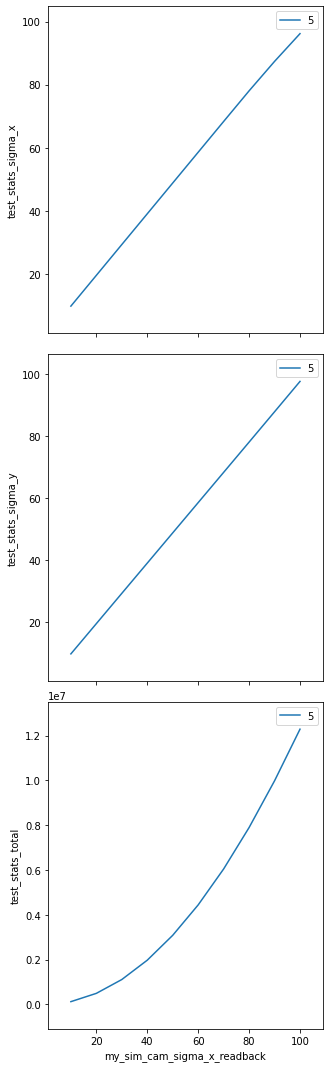

In [16]:
from bluesky.plans import scan

RE(scan([my_sim_cam],my_sim_cam_sigma_x,10,100,my_sim_cam_sigma_y,10,100,10))


**Using V33**

https://nsls-ii.github.io/ophyd/area-detector.html#callbacks 

In [74]:
# create the SimDetector Device with a TIFF filesave mixin

# https://github.com/NSLS-II-OPLS/profile_collection/blob/6960f16e4b622e1cc2bf4703cfa07e3340a617f2/startup/45-pilatus.py#L53-L54

from ophyd import ( Component as Cpt, ADComponent, Device, PseudoPositioner,
                    EpicsSignal, EpicsSignalRO, EpicsMotor,
                    ROIPlugin, ImagePlugin,
                    SingleTrigger, PilatusDetector,
                    OverlayPlugin, FilePlugin, TIFFPlugin, SimDetector, TIFFPlugin, StatsPlugin, SimDetectorCam, ColorConvPlugin)
from ophyd.areadetector.filestore_mixins import FileStoreTIFFIterativeWrite
from ophyd import Component as Cpt

from ophyd.areadetector.plugins import StatsPlugin_V33
from bessyii.ad33 import StatsPluginV33
from bessyii.ad33 import SingleTriggerV33

class SimDetectorCamV33(SimDetectorCam):
    '''This is used to update the SimDetectorCam to AD33.'''

    wait_for_plugins = Cpt(EpicsSignal, 'WaitForPlugins',
                           string=True, kind='config')

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.stage_sigs['wait_for_plugins'] = 'Yes'

    def ensure_nonblocking(self):
        self.stage_sigs['wait_for_plugins'] = 'Yes'
        for c in self.parent.component_names:
            cpt = getattr(self.parent, c)
            if cpt is self:
                continue
            if hasattr(cpt, 'ensure_nonblocking'):
                cpt.ensure_nonblocking()
    


class SimDetector(SimDetector):
    cam = Cpt(SimDetectorCamV33, 'cam1:')

class TIFFPluginWithFileStore(TIFFPlugin, FileStoreTIFFIterativeWrite):
    ...

class MySimDetectorV33(SingleTriggerV33, SimDetector):
    tiff = Cpt(TIFFPluginWithFileStore,
               suffix="TIFF1:",
               write_path_template="/home/emil/Apps/autosave/images/")
    stats = Cpt(StatsPluginV33, 'Stats1:')
    image = Cpt(ImagePlugin, 'image1:')
    colour = Cpt(ColorConvPlugin, 'CC1:')
    
    

def set_detectorV33(det):

    det.tiff.kind = 'normal' 
    det.stats.kind = 'hinted'
    det.colour.kind = 'normal'
    det.image.kind = 'hinted'
    det.stats.total.kind = 'hinted'
    det.stats.centroid.x.kind = 'hinted' 
    det.stats.centroid.y.kind = 'hinted'
    det.stats.sigma_x.kind = 'hinted'
    det.stats.sigma_y.kind = 'hinted'
    det.cam.ensure_nonblocking()
    det.tiff.nd_array_port.put(det.colour.port_name.get()) # makes the tiff plugin take the output of the colour change plugin

In [75]:
my_sim_camV33 = MySimDetectorV33('SISSY1EX:Simdetector1:', name='test')

In [76]:
set_detectorV33(my_sim_camV33)



Transient Scan ID: 9     Time: 2021-08-25 13:09:10
Persistent Unique Scan ID: 'a125745f-7282-4e7d-aac0-bc43741bfdef'
New stream: 'primary'
+-----------+------------+-----------------------------+-----------------------------+--------------------+--------------------+------------------+
|   seq_num |       time | my_sim_cam_sigma_x_readback | my_sim_cam_sigma_y_readback | test_stats_sigma_x | test_stats_sigma_y | test_stats_total |
+-----------+------------+-----------------------------+-----------------------------+--------------------+--------------------+------------------+
|         1 | 13:09:10.2 |                          10 |                          10 |                9.8 |                9.8 |           123376 |
|         2 | 13:09:10.5 |                          20 |                          20 |               19.5 |               19.5 |           493600 |
|         3 | 13:09:10.9 |                          30 |                          30 |               29.3 |            

('a125745f-7282-4e7d-aac0-bc43741bfdef',)

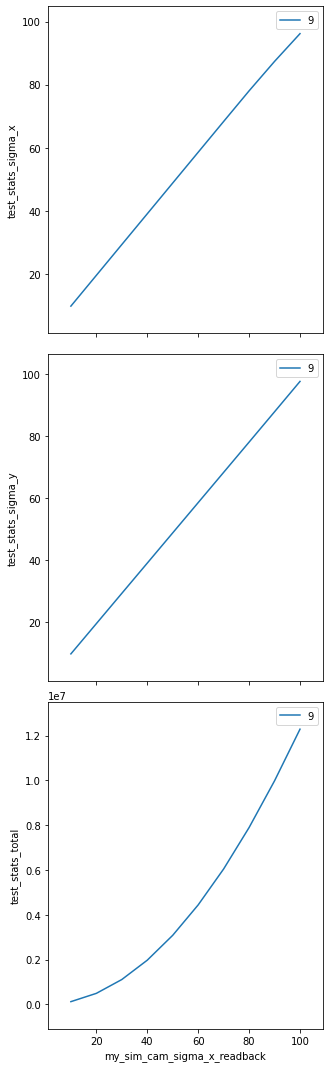

In [77]:
RE(scan([my_sim_camV33],my_sim_cam_sigma_x,10,100,my_sim_cam_sigma_y,10,100,10))